# Large Scale (Synthetic Data Generation) for Masked image segmentation using Blender 3D software for DEEP LEARNING - Computer Vision(YOLO)
        -by Abhishek Verma

#Usign Blender for Synthetic Data generation, rename of both rendered image compositor image should be same, during rendering, images must save in 2 different folders named as (Images & Mask)

* imp Notes:-
1. To hide a object select object and and enable Mask -> HOLDOUT
2. dont set any name for compositor File output saving path
3. background = Film > Transparent
4. object to be trained should be white(255,255,255) and background(0,0,0)

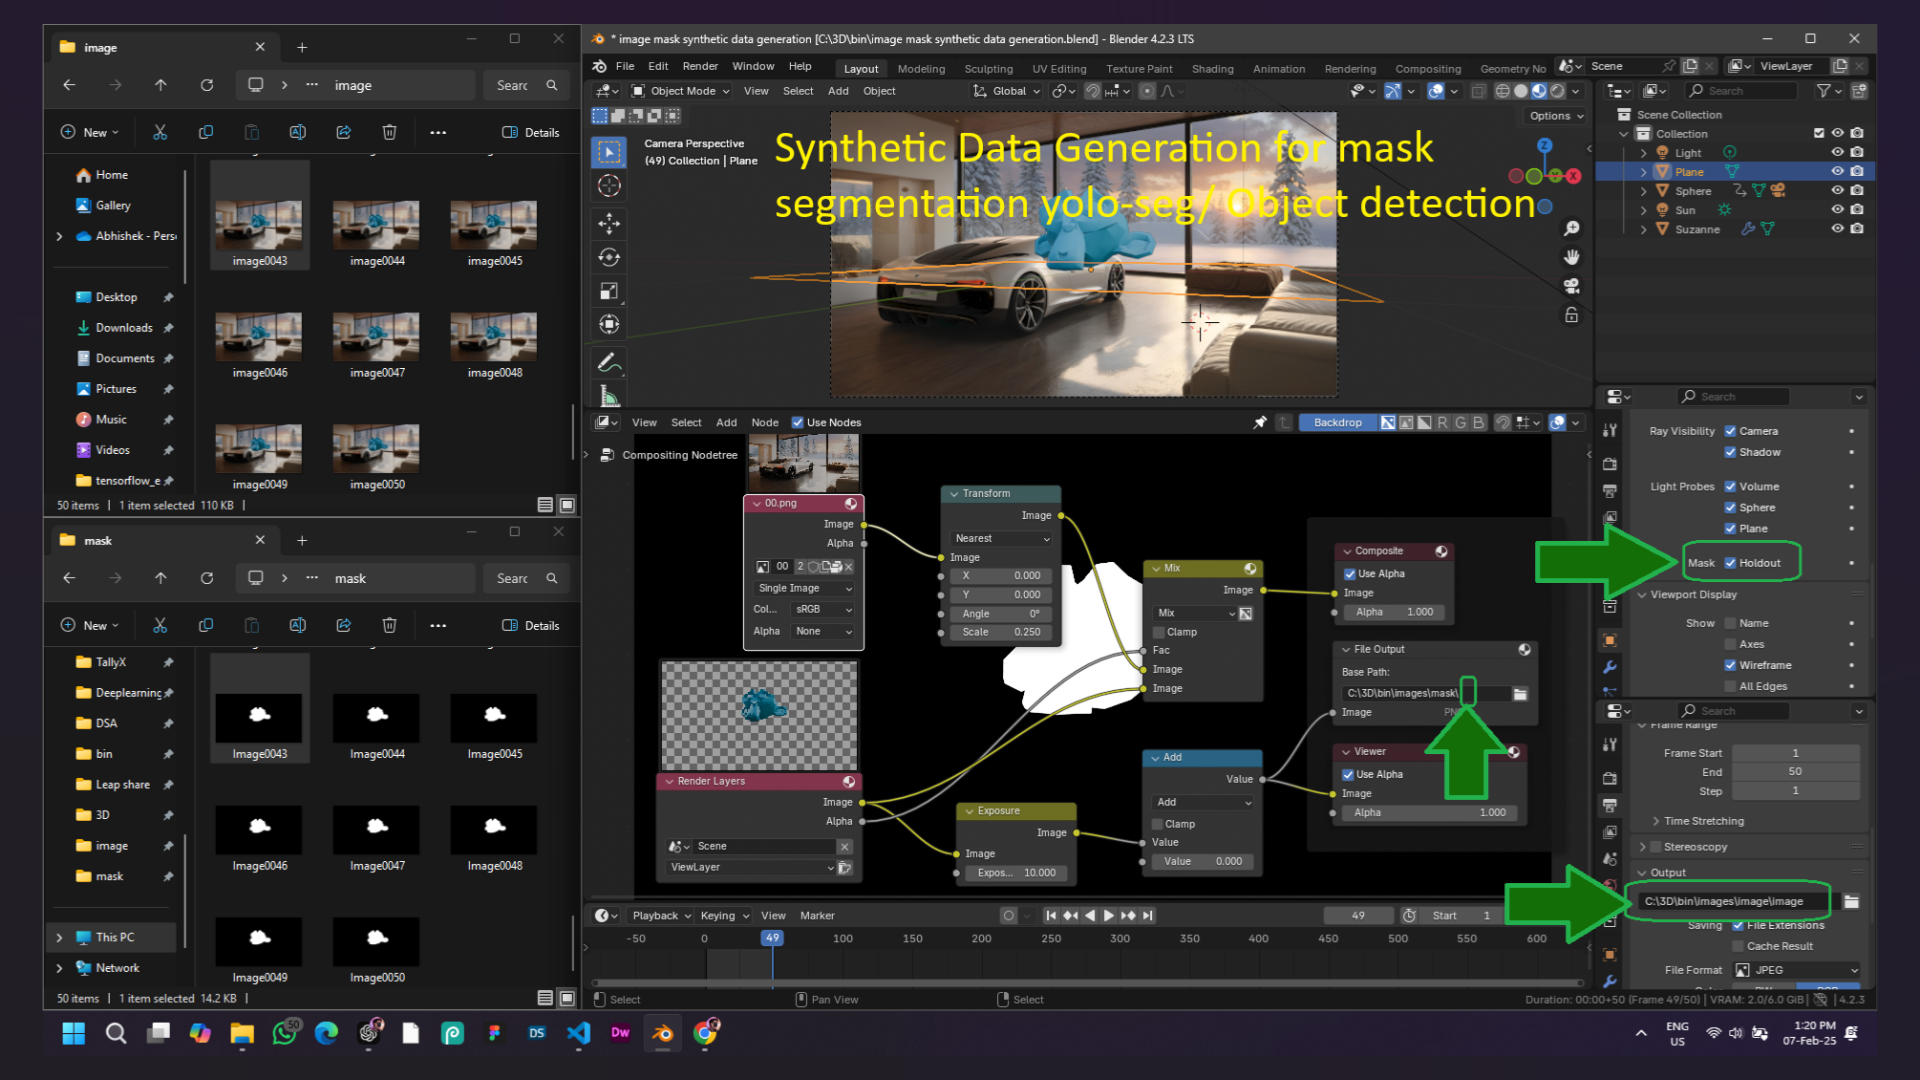

#Convert Masked-image to polygons annotations .txt file------------black = background/ white = object masked

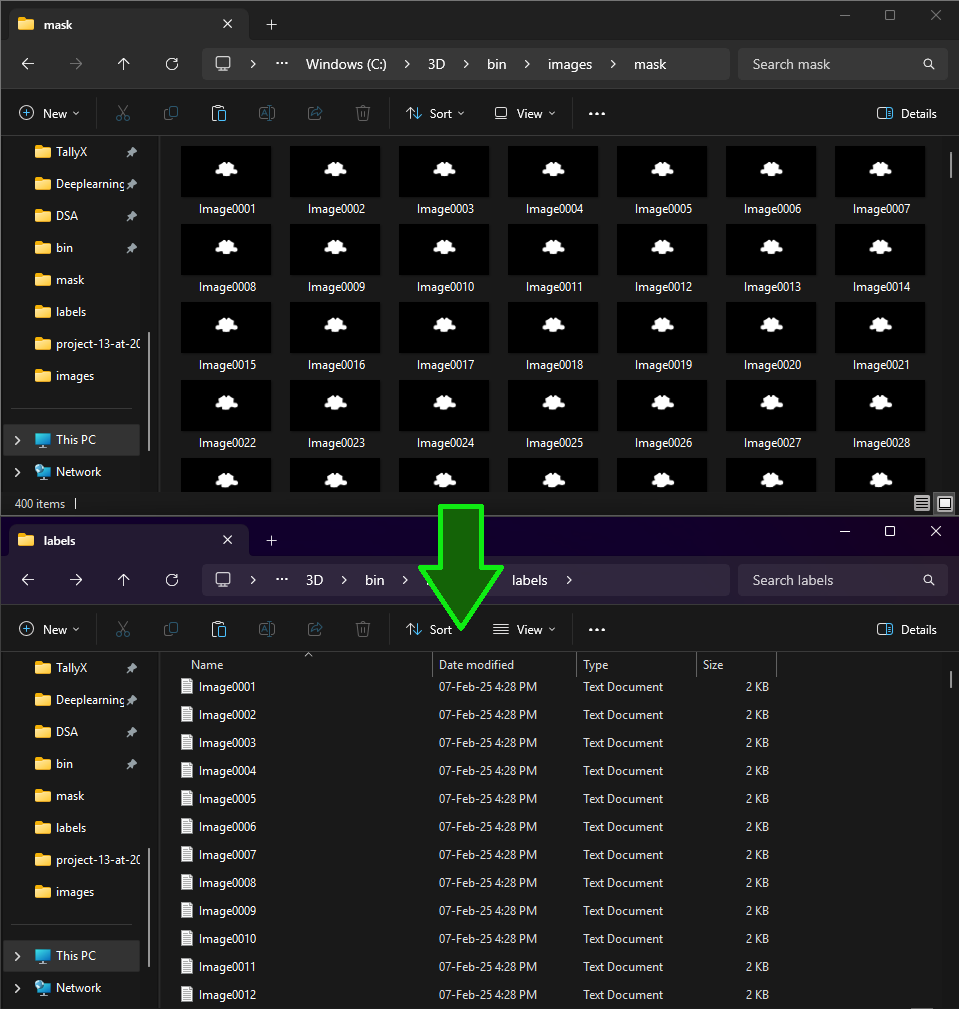

In [ ]:
import cv2
import numpy as np
import os

def mask_to_polygon(mask_image, epsilon=0.002):  # Use adaptive polygon approximation
    # Read the mask in grayscale
    img = cv2.imread(mask_image, cv2.IMREAD_GRAYSCALE)

    # Apply binary threshold
    _, binary_mask = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

    # Find contours with hierarchy detection
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    polygons = []

    for contour in contours:
        # Approximate the contour to reduce points adaptively
        epsilon_value = epsilon * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon_value, True)

        # Normalize points to YOLO format
        normalized_points = [(point[0][0] / img.shape[1], point[0][1] / img.shape[0]) for point in approx]
        
        # Ensure the polygon is closed
        if len(normalized_points) > 2 and normalized_points[0] != normalized_points[-1]:
            normalized_points.append(normalized_points[0])

        # Format as YOLO annotation
        polygons.append(" ".join([f"{x} {y}" for x, y in normalized_points]))

    return polygons

# Input/output folders
input_folder = "C:\\3D\\bin\\images\\mask"  
output_folder = "C:\\3D\\bin\\images\\label"  

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Process all mask images
for mask_image in os.listdir(input_folder):
    if mask_image.endswith(".png"):  
        mask_image_path = os.path.join(input_folder, mask_image)
        
        # Convert mask to YOLO polygons
        polygons = mask_to_polygon(mask_image_path, epsilon=0.002)
        
        # Save the polygons as YOLO labels
        label_file_path = os.path.join(output_folder, os.path.splitext(mask_image)[0] + ".txt")
        
        with open(label_file_path, "w") as f:
            for polygon in polygons:
                f.write(f"0 {polygon}\n")  

        print(f"Saved annotations for {mask_image}")

print("Finished processing all images.")


#Check polygons correctness on the image

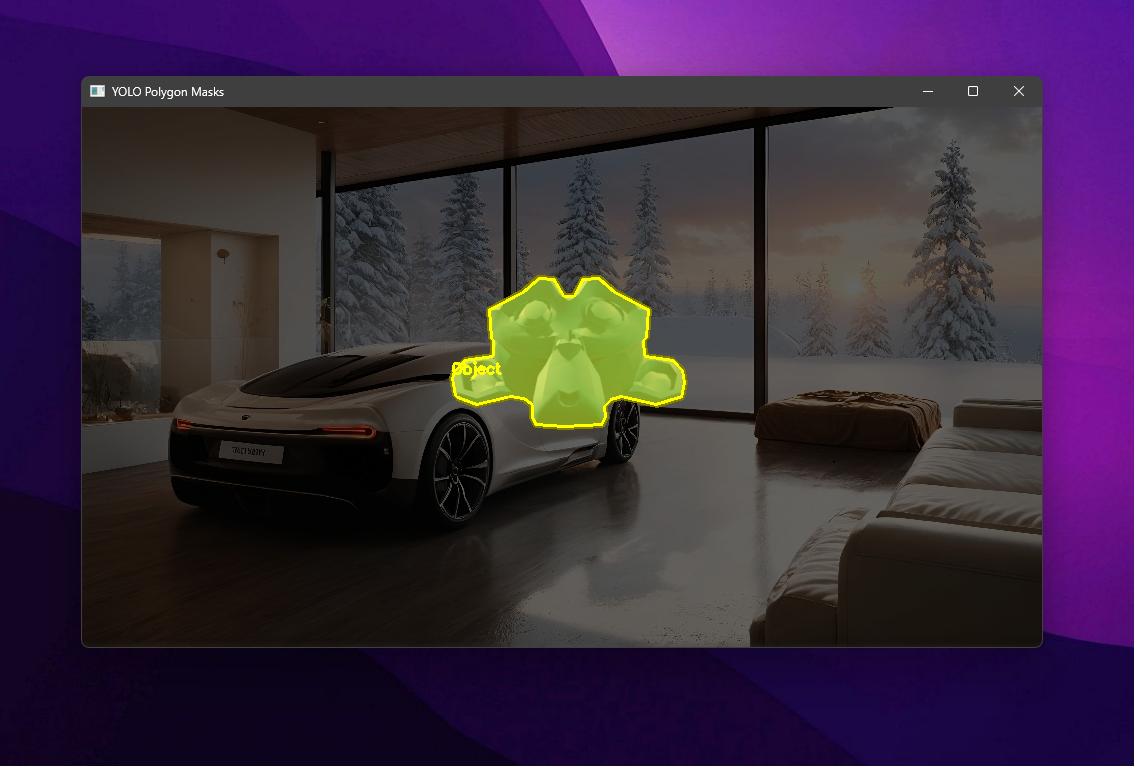

In [ ]:
import cv2
import numpy as np

def draw_yolo_polygons(image_path, label_path, class_names=None):
    # Load image
    image = cv2.imread(image_path)
    height, width, _ = image.shape  # Ensure this is 640x640
    
    with open(label_path, "r") as file:
        lines = file.readlines()
    
    for line in lines:
        data = line.strip().split()
        class_id = int(data[0])
        points = list(map(float, data[1:]))
        
        # Convert YOLO format (normalized) to pixel coordinates
        polygon_points = []
        for i in range(0, len(points), 2):
            x = int(points[i] * width)
            y = int(points[i + 1] * height)
            polygon_points.append((x, y))

        # Ensure that the polygon is closed, no diagonals
        polygon_points = np.array(polygon_points, np.int32)
        polygon_points = polygon_points.reshape((-1, 1, 2))
        
        # Drawing the polygon outline (yellow) with a smooth edge
        cv2.polylines(image, [polygon_points], isClosed=True, color=(0, 255, 255), thickness=3)  # Yellow
        
        # Fill the polygon with a semi-transparent color for selection effect
        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.fillPoly(mask, [polygon_points], (0, 255, 255))  # Fill yellow
        alpha = 0.5  # Adjust transparency level for selection effect
        cv2.addWeighted(mask, alpha, image, 1 - alpha, 0, image)

        # Add label text if class names are provided
        if class_names:
            label = class_names[class_id] if class_id < len(class_names) else str(class_id)
            # Place the label near the top-left corner of the polygon
            cv2.putText(image, label, (polygon_points[0][0][0], polygon_points[0][0][1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 255), 2)

    # Show the image with polygon outlines
    cv2.imshow("YOLO Polygon Masks", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Example usage (Ensure these paths are correct)
image_path = r"C:\\3D\bin\\images\\images\\train\\Image0001.jpg"   # Image file
label_path = r"C:\\3D\bin\\images\\labels\\train\\Image0001.txt"   # YOLO label file
class_names = ["Object"]  # Add correct class names if available

draw_yolo_polygons(image_path, label_path, class_names)


#Set the correct Directory structure

Required files:-
1. dataset.yaml
1. classes.txt


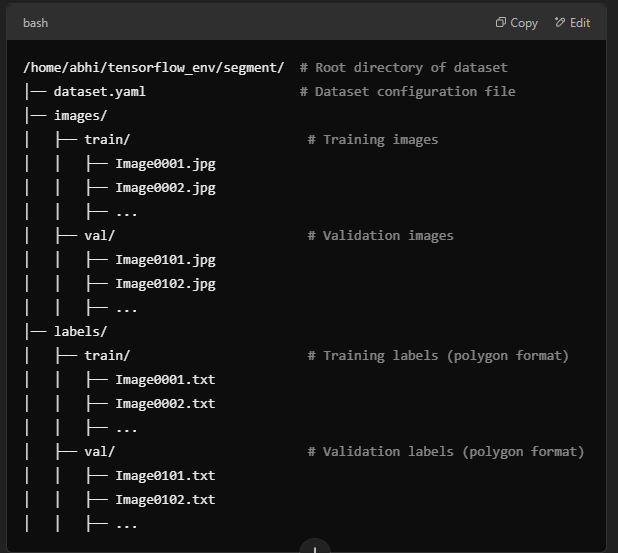

#Train the model using dataset.yaml

* dataset.yaml data example:-

        path: /home/abhi/tensorflow_env/segment/ # Root directory of your dataset
    
        train: /home/abhi/tensorflow_env/segment/images/train/ # Path to training images
    
        val: /home/abhi/tensorflow_env/segment/images/val/  # Path to validation images
    
        nc: 1  # Number of classes (1 for 'match')
    
        names: ["Monkey"]  # Class name


#Train yolo model(neural network) using image-segmentation-polygons labels dataset----------------------------start-------------

after training, trained model present in same_dir > runs > train > weights > last.pt

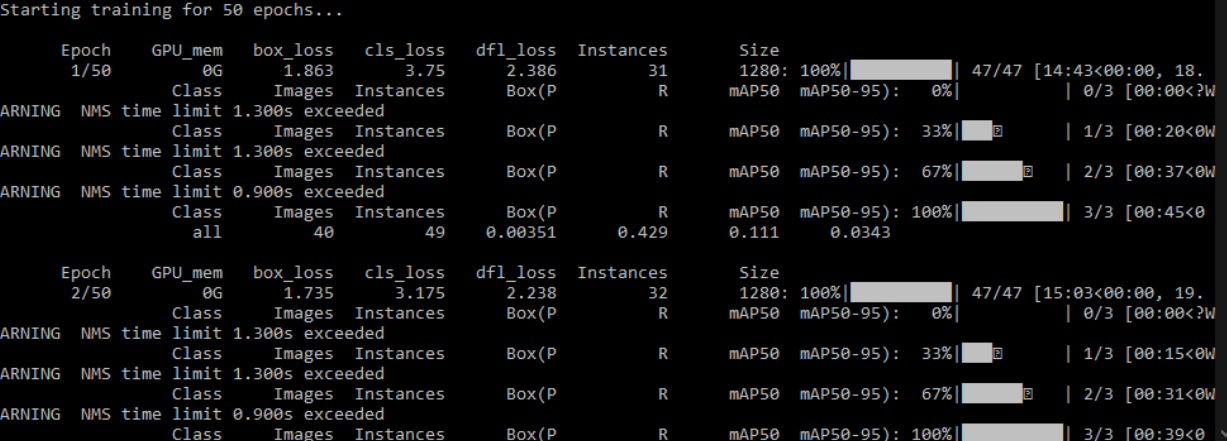

In [ ]:
from ultralytics import YOLO

# Define the path to your dataset YAML file
dataset_yaml_path = "dataset.yaml"

# Initialize the YOLO model with the configuration for segmentation (YOLOv8 small, for example)
model = YOLO('yolov8n-seg.yaml')  # You can choose other variants like yolov8l-seg.yaml

# Train the model
model.train(data=dataset_yaml_path, epochs=100, imgsz=640)

# Optionally, you can save the trained model
model.save("trained_model.pt")
#yolo task=segment mode=train model=yolov8n-seg.pt data=dataset.yaml epochs=100


#IMAGE------------Detect object-segment using IMAGE 

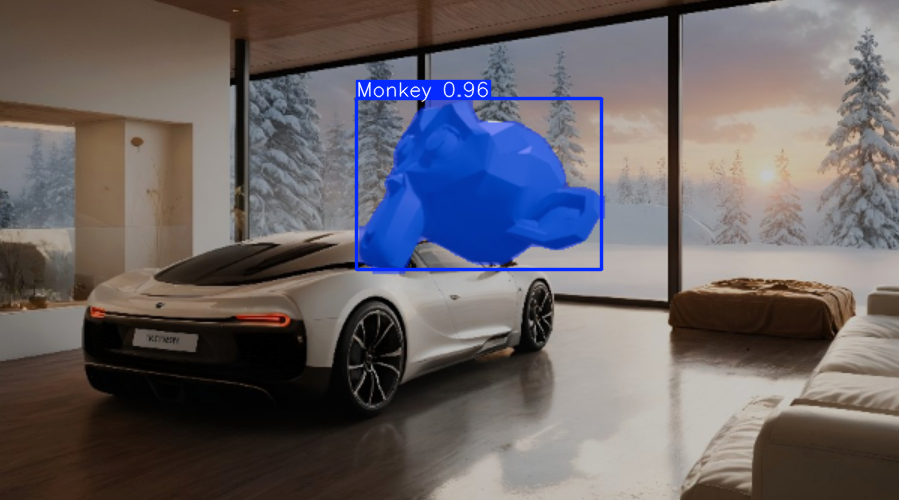

In [1]:
from ultralytics import YOLO
import cv2

# Load the YOLOv8 segmentation model
model = YOLO("monkey_predict_model.pt").to('cuda')  # Replace with your model path

# Load an image
image_path = "C:\\3D\\bin\\images\\images\\train\\Image0085.jpg"  # Change to your image path
image = cv2.imread(image_path)

# Run inference on the image
results = model(image)

# Check if results are returned as a list
if isinstance(results, list):
    result = results[0]  # Get the first result (usually there's only one)
else:
    result = results  # Otherwise, use the result directly

# Plot the results (segmentation masks will automatically be drawn)
result.show()  # This will display the image with segmentation results

# Optionally, you can also save the results to a file
#result.save()  # Saves the result to 'runs/detect/exp'






0: 384x640 1 Monkey, 75.6ms
Speed: 5.0ms preprocess, 75.6ms inference, 123.9ms postprocess per image at shape (1, 3, 384, 640)


#VIDEO--------------------------Detect object-segment using VIDEO



In [2]:
import cv2
from ultralytics import YOLO

# Load trained model and ensure it uses the GPU
model = YOLO("monkey_predict_model.pt").to('cuda')  # Load on GPU

# Open video file (replace 'video.mp4' with the path to your video)
video_path = "C:\\3D\\bin\\images\\vid0001-0400.mkv"
cap = cv2.VideoCapture(video_path)

# Check if the video was opened successfully
if not cap.isOpened():
    print("Error: Couldn't open video file.")
    exit()

# Create a single window for displaying results
cv2.namedWindow("YOLOv8 Video Detection", cv2.WINDOW_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Resize the frame to lower resolution for faster processing (e.g., 640x480)
    frame_resized = cv2.resize(frame, (640, 480))

    # Run YOLO on the resized frame with a lower confidence threshold
    results = model(frame_resized, conf=0.6)

    # Check if results are available and have detections
    if results:
        # Access the predictions (results[0] is a Result object)
        result = results[0]  # This is a Result object
        
        if result.boxes:
            # Access the bounding boxes and confidence scores
            boxes = result.boxes
            if len(boxes) > 0:  # Check if any boxes are detected
                # Plot results on the frame
                annotated_frame = result.plot()

                # Display the annotated frame
                cv2.imshow("YOLOv8 Video Detection", annotated_frame)
            else:
                # Display the original frame if no boxes detected
                cv2.imshow("YOLOv8 Video Detection", frame_resized)
        else:
            # Display the original frame if no detections
            cv2.imshow("YOLOv8 Video Detection", frame_resized)
    else:
        # Display the original frame if no detections
        cv2.imshow("YOLOv8 Video Detection", frame_resized)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



0: 480x640 1 Monkey, 75.1ms
Speed: 5.0ms preprocess, 75.1ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 32.7ms
Speed: 5.0ms preprocess, 32.7ms inference, 6.1ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 28.0ms
Speed: 3.0ms preprocess, 28.0ms inference, 7.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 28.5ms
Speed: 3.0ms preprocess, 28.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 11.0ms
Speed: 2.0ms preprocess, 11.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 12.0ms
Speed: 1.0ms preprocess, 12.0ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 13.5ms
Speed: 1.2ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Monkey, 13.0ms
Speed: 1.0ms preprocess, 13.0ms inference, 3.0ms postprocess per image at shape (1, 3, 48

#CAMERA-----------------Detect object-segment using CAMERA 

In [ ]:
import cv2
from ultralytics import YOLO

# Load trained model and ensure it uses the GPU
model = YOLO("monkey_predict_model.pt") # Load on GPU

# Open webcam
cap = cv2.VideoCapture(0)

# Create a single window for displaying results
cv2.namedWindow("YOLOv8 Webcam Detection", cv2.WINDOW_NORMAL)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLO on the frame with a lower confidence threshold
    results = model(frame, conf=0.94)

    # Check if results are available and have detections
    if results:
        # Access the predictions (results[0] is a Result object)
        result = results[0]  # This is a Result object
        
        if result.boxes:
            # Access the bounding boxes and confidence scores
            boxes = result.boxes
            if len(boxes) > 0:  # Check if any boxes are detected
                # Plot results on the frame
                annotated_frame = result.plot()

                # Display the annotated frame
                cv2.imshow("YOLOv8 Webcam Detection", annotated_frame)
            else:
                # Display the original frame if no boxes detected
                cv2.imshow("YOLOv8 Webcam Detection", frame)
        else:
            # Display the original frame if no detections
            cv2.imshow("YOLOv8 Webcam Detection", frame)
    else:
        # Display the original frame if no detections
        cv2.imshow("YOLOv8 Webcam Detection", frame)

    # Exit when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


#DISPLAY----------------Detect object-segment using DISPLAY CAPTURE

*pip install opencv-python numpy mss ultralytics


In [ ]:
import cv2
import numpy as np
import mss
from ultralytics import YOLO

# Load YOLO model on GPU
model = YOLO("monkey_predict_model.pt").to('cuda')

# Define screen capture region (full screen)
with mss.mss() as sct:
    screen_width = sct.monitors[1]["width"]
    screen_height = sct.monitors[1]["height"]
    monitor = {"top": 0, "left": 0, "width": screen_width, "height": screen_height}

# Create a window for displaying the screen
cv2.namedWindow("Screen Detection", cv2.WINDOW_NORMAL)
cv2.resizeWindow("Screen Detection", 800, 450)  # Resize window for a smaller display

while True:
    with mss.mss() as sct:
        # Capture the screen
        screenshot = sct.grab(monitor)

        # Convert to a NumPy array
        frame = np.array(screenshot)

        # Convert from BGRA to BGR (OpenCV format)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGRA2BGR)

        # Run YOLO on the captured screen
        results = model(frame, conf=0.6)

        # Annotate detected objects
        annotated_frame = results[0].plot()

        # Resize the frame for display
        small_frame = cv2.resize(annotated_frame, (800, 450))

        # Show the captured screen with predictions
        cv2.imshow("Screen Detection", small_frame)

    # Exit on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
